# Analysis of US Mass shootings

## 1) Data Preparation 

In [1]:
#Import all required libraries for reading data, analysing and visualizing data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

In [2]:
shootings = pd.read_csv('Mass Shootings Dataset Ver 5.csv',encoding='latin-1')

In [3]:
shootings.shape

(323, 21)

In [4]:
shootings.head(2)

,S#,Title,Location,Date,Incident Area,Open/Close Location,Target,Cause,Summary,Fatalities,...,Total victims,Policeman Killed,Age,Employeed (Y/N),Employed at,Mental Health Issues,Race,Gender,Latitude,Longitude
0,1,Texas church mass shooting,"Sutherland Springs, TX",11/5/2017,Church,Close,random,unknown,"Devin Patrick Kelley, 26, an ex-air force offi...",26,...,46,0.0,26,NaN,NaN,No,White,M,NaN,NaN
1,2,Walmart shooting in suburban Denver,"Thornton, CO",11/1/2017,Wal-Mart,Open,random,unknown,"Scott Allen Ostrem, 47, walked into a Walmart ...",3,...,3,0.0,47,NaN,NaN,No,White,M,NaN,NaN


In [5]:
shootings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 323 entries, 0 to 322
Data columns (total 21 columns):
S#                      323 non-null int64
Title                   323 non-null object
Location                278 non-null object
Date                    323 non-null object
Incident Area           261 non-null object
Open/Close Location     295 non-null object
Target                  318 non-null object
Cause                   246 non-null object
Summary                 323 non-null object
Fatalities              323 non-null int64
Injured                 323 non-null int64
Total victims           323 non-null int64
Policeman Killed        317 non-null float64
Age                     179 non-null object
Employeed (Y/N)         67 non-null float64
Employed at             41 non-null object
Mental Health Issues    323 non-null object
Race                    321 non-null object
Gender                  323 non-null object
Latitude                303 non-null float64
Longitude         

There are 323 shootings and 21 features in the dataset.

- S# - Shooting# - descending order                 
- Title - Description about the shooting             
- Location - location of the mass shooting            
- Date - date of shooting  
- Incident Area - Area where shooting occurred  
- Open/Close Location - Whether the location is closed or opened  
- Target - Is it a targeted shooting or random one? If so, who was targeted  
- Cause  - cause for the shooting  
- Summary - brief summary of the shooting. Who shot and the background etc.  
- Fatalities - how many were dead during/after the shooting  
- Injured - how many were injured during/after the shooting  
- Total victims - total victims impacted during the shooting  
- Policeman Killed - Number of policeman killed  
- Age - Age of the gunman committing the crime  
- Employeed (Y/N) - Was the gunman employed  
- Employed at - If employed, employment details of the gunman  
- Mental Health Issues - Was the gunman mentally ill?  
- Race - race of the gunman  
- Gender - race of the gunman  
- Latitude - locations latitude              
- Longitude - locations longitude  

## 2) Data Processing

In [6]:
#Which features are available in the dataset?
shootings.columns.values  

array(['S#', 'Title', 'Location', 'Date', 'Incident Area',
       'Open/Close Location', 'Target', 'Cause', 'Summary', 'Fatalities',
       'Injured', 'Total victims', 'Policeman Killed', 'Age',
       'Employeed (Y/N)', 'Employed at', 'Mental Health Issues', 'Race',
       'Gender', 'Latitude', 'Longitude'], dtype=object)

**What are the missing values???**

In [7]:
shootings.isnull().sum()

S#                        0
Title                     0
Location                 45
Date                      0
Incident Area            62
Open/Close Location      28
Target                    5
Cause                    77
Summary                   0
Fatalities                0
Injured                   0
Total victims             0
Policeman Killed          6
Age                     144
Employeed (Y/N)         256
Employed at             282
Mental Health Issues      0
Race                      2
Gender                    0
Latitude                 20
Longitude                20
dtype: int64

There are 45 missing locations, 62 missing incident areas and 5 missing Target. Lets try to figure whether we can figure out these from the title and summary.

In [8]:
#Create new columns for year and month based on the shooting date
from datetime import datetime
shootings['Date'] = pd.to_datetime(shootings['Date'])
shootings['Shooting_Year'] = shootings['Date'].dt.year
shootings['Shooting_Month'] = shootings['Date'].dt.month

### Impute Missing Values

 **2.1) Identifying Location from Title**

In [9]:
#My logic is based on the assumption that some titles have city and state separated by comma and some titles just have the state.
shootings['loc1'] = shootings.Title.str.extract('([A-Za-z]+, [A-Za-z]+)', expand=False)
shootings['loc2']= shootings.Title.str.extract('([A-Za-z]+ )', expand=False)

In [10]:
# For null values of the location column, update the new column location1 with values from loc1. If location1 is still null, update with loc2
for i in range(len(shootings)):
    if pd.isnull(shootings.loc[i,'Location']):
        shootings.loc[i,'Location1'] = shootings.loc[i,'loc1']
        if pd.isnull(shootings['Location1'][i]):
            shootings.loc[i,'Location1'] = shootings.loc[i,'loc2']
    else:
        shootings.loc[i,'Location1'] = shootings.loc[i,'Location']

In [11]:
#Drop all unwanted columns and just retain location1 - rename it to Location
shootings = shootings.drop(['Location','loc1','loc2'], axis=1)
shootings.rename(columns={'Location1': 'Location'}, inplace=True)

**2.2) Creating State from location - Making sure the state names are in the same format**

In [12]:
shootings['State'] = shootings['Location'].str.rpartition(',')[2]
shootings['State'][shootings.State.str.len()==3].value_counts().head(2)

 CA    5
 VA    3
Name: State, dtype: int64

In [13]:

shootings['State'].replace([' CA',' VA',' WA',' NM',' LA',' GA',' MD',' FL',' CO',' TX',' PA',' TN',' AZ',' NV',' AL',' DE',' NJ'],
                           ['California','Virginia','Washington','New Mexico','Louisiana','Georgia','Maryland','Florida',
                            'Colorado','Texas','Pennsylvania','Tennessee','Arizona','Nevada','Alabama','Delaware','New Jersey'], inplace=True)
shootings['State'].value_counts().head()

 California    29
 Florida       21
 Texas         16
 Georgia       14
 Washington    14
Name: State, dtype: int64

**2.3) Updating the redundant values - GENDER**

In [14]:
shootings.Gender.value_counts()

Male           272
Unknown         21
M               20
Female           5
Male/Female      4
M/F              1
Name: Gender, dtype: int64

In [15]:
shootings['Gender'].replace(['M', 'M/F'], ['Male', 'Male/Female'], inplace=True)
shootings.Gender.value_counts()

Male           292
Unknown         21
Female           5
Male/Female      5
Name: Gender, dtype: int64

**2.4) Updating the redundant values - RACE**

In [16]:
shootings['Race'].value_counts()

White American or European American                    122
Black American or African American                      76
Unknown                                                 42
Some other race                                         20
white                                                   12
Asian American                                          11
White                                                    9
Asian                                                    6
Black                                                    5
Latino                                                   5
black                                                    3
Native American or Alaska Native                         3
Other                                                    2
Two or more races                                        2
Asian American/Some other race                           1
Black American or African American/Unknown               1
White American or European American/Some other Race     

In [17]:
shootings['Race'].replace(['White American or European American', 'white', 'White American or European American/Some other Race'], ['White', 'White', 'White'], inplace=True)
shootings['Race'].replace(['Black American or African American', 'black', 'Black American or African American/Unknown'], ['Black', 'Black', 'Black'], inplace=True)
shootings['Race'].replace(['Asian', 'Asian American/Some other race'], ['Asian American', 'Asian American'], inplace=True)
shootings['Race'].replace(['Unknown', 'Some other race', 'Two or more races'], ['Other', 'Other' ,'Other'], inplace=True)
shootings['Race'].replace(['Native American or Alaska Native'], ['Native American'], inplace=True)
shootings['Race'].value_counts()

White              144
Black               85
Other               66
Asian American      18
Latino               5
Native American      3
Name: Race, dtype: int64

**2.5) Updating the redundant values - MENTAL HEALTH ISSUES**

In [18]:
shootings['Mental Health Issues'].value_counts()

Unknown    110
Yes        106
No          93
Unclear     13
unknown      1
Name: Mental Health Issues, dtype: int64

In [19]:
shootings['Mental Health Issues'].replace(['Unclear' ,'unknown'], ['Unknown', 'Unknown'], inplace=True)
shootings['Mental Health Issues'].value_counts()

Unknown    124
Yes        106
No          93
Name: Mental Health Issues, dtype: int64

**2.6) Updating the redundant values - INCIDENT AREA**

In [20]:
shootings['Incident Area'].value_counts().tail()

Home+Restaurant                 1
Home+Stock Exchange Office      1
Café+Walmart                    1
opening of motorcycle season    1
manufacturer Fiamma Inc.        1
Name: Incident Area, dtype: int64

In [21]:
#Update the Incident area to common groups.
shootings['Area'] = np.nan
shootings.loc[shootings['Incident Area'].str.contains("school",case=False, na=False), 'Area'] = 'School'
shootings.loc[shootings['Incident Area'].str.contains("University",case=False, na=False), 'Area'] = 'School'
shootings.loc[shootings['Incident Area'].str.contains("college",case=False, na=False), 'Area'] = 'School'
shootings.loc[shootings['Incident Area'].str.contains("dormitory",case=False, na=False), 'Area'] = 'School'
shootings.loc[shootings['Incident Area'].str.contains("lecture",case=False, na=False), 'Area'] = 'School'
shootings.loc[shootings['Incident Area'].str.contains("scool",case=False, na=False), 'Area'] = 'School'
shootings.loc[shootings['Incident Area'].str.contains("academy",case=False, na=False), 'Area'] = 'School'
shootings.loc[shootings['Incident Area'].str.contains("classroom",case=False, na=False), 'Area'] = 'School'
shootings.loc[shootings['Incident Area'].str.contains("apartment",case=False, na=False), 'Area'] = 'Home'
shootings.loc[shootings['Incident Area'].str.contains("house",case=False, na=False), 'Area'] = 'Home'
shootings.loc[shootings['Incident Area'].str.contains("home",case=False, na=False), 'Area'] = 'Home'
shootings.loc[shootings['Incident Area'].str.contains("shop",case=False, na=False), 'Area'] = 'Shop'
shootings.loc[shootings['Incident Area'].str.contains("Store",case=False, na=False), 'Area'] = 'Shop'
shootings.loc[shootings['Incident Area'].str.contains("Restaurant",case=False, na=False), 'Area'] = 'Shop'
shootings.loc[shootings['Incident Area'].str.contains("salon",case=False, na=False), 'Area'] = 'Shop'
shootings.loc[shootings['Incident Area'].str.contains("spa",case=False, na=False), 'Area'] = 'Shop'
shootings.loc[shootings['Incident Area'].str.contains("Cafe",case=False, na=False), 'Area'] = 'Shop'
shootings.loc[shootings['Incident Area'].str.contains("grocery",case=False, na=False), 'Area'] = 'Shop'
shootings.loc[shootings['Incident Area'].str.contains("mart",case=False, na=False), 'Area'] = 'Shop'
shootings.loc[shootings['Incident Area'].str.contains("Office",case=False, na=False), 'Area'] = 'Work'
shootings.loc[shootings['Incident Area'].str.contains("Company",case=False, na=False), 'Area'] = 'Work'
shootings.loc[shootings['Incident Area'].str.contains("work",case=False, na=False), 'Area'] = 'Work'
shootings.loc[shootings['Incident Area'].str.contains("conference",case=False, na=False), 'Area'] = 'Work'
shootings.loc[shootings['Incident Area'].str.contains("firm",case=False, na=False), 'Area'] = 'Work'
shootings.loc[shootings['Incident Area'].str.contains("street",case=False, na=False), 'Area'] = 'Road'
shootings.loc[shootings['Incident Area'].str.contains("lot",case=False, na=False), 'Area'] = 'Road'
shootings.loc[shootings['Incident Area'].str.contains("walk",case=False, na=False), 'Area'] = 'Road'
shootings.loc[shootings['Incident Area'].str.contains("highway",case=False, na=False), 'Area'] = 'Road'
shootings.loc[shootings['Incident Area'].str.contains("interstate",case=False, na=False), 'Area'] = 'Road'
shootings.loc[shootings['Incident Area'].str.contains("club",case=False, na=False), 'Area'] = 'Pub-Club'
shootings.loc[shootings['Incident Area'].str.contains("pub",case=False, na=False), 'Area'] = 'Pub-Club'
shootings.loc[shootings['Incident Area'].str.contains("gas",case=False, na=False), 'Area'] = 'Gas-Station'
shootings.loc[shootings['Incident Area'].str.contains("party",case=False, na=False), 'Area'] = 'Party'
shootings.loc[shootings['Incident Area'].str.contains("airport",case=False, na=False), 'Area'] = 'Airport'
shootings.loc[shootings['Incident Area'].str.contains("clinic",case=False, na=False), 'Area'] = 'Hospital'
shootings.loc[shootings['Incident Area'].str.contains("Hospital",case=False, na=False), 'Area'] = 'Hospital'
shootings.loc[shootings['Incident Area'].str.contains("church",case=False, na=False), 'Area'] = 'Religious'
shootings.loc[shootings['Incident Area'].str.contains("temple",case=False, na=False), 'Area'] = 'Religious'
shootings.loc[shootings['Incident Area'].str.contains("monastery",case=False, na=False), 'Area'] = 'Religious'
shootings.Area.fillna(shootings['Incident Area'],inplace=True)

In [22]:
shootings['Area'].value_counts().head(10)

Home                   69
School                 48
Shop                   29
Work                   21
Pub-Club               16
Road                   11
Religious               8
Party                   7
Hospital                3
Fort Hood Army Post     3
Name: Area, dtype: int64

**2.7) Updating the redundant values - TARGET**

In [23]:
shootings['Target'].value_counts().tail()

protestors          1
Trooper             1
Ex-GirlFriend       1
House Owner         1
Students+Parents    1
Name: Target, dtype: int64

In [24]:
shootings['FTarget'] = np.nan
shootings.loc[shootings['Target'].str.contains("family",case=False, na=False), 'FTarget'] = 'Family'
shootings.loc[shootings['Target'].str.contains("Ex-",case=False, na=False), 'FTarget'] = 'Family'
shootings.loc[shootings['Target'].str.contains("coworker",case=False, na=False), 'FTarget'] = 'Coworkers'
shootings.loc[shootings['Target'].str.contains("employee",case=False, na=False), 'FTarget'] = 'Coworkers'
shootings.loc[shootings['Target'].str.contains("Student",case=False, na=False), 'FTarget'] = 'School'
shootings.loc[shootings['Target'].str.contains("player",case=False, na=False), 'FTarget'] = 'School'
shootings.loc[shootings['Target'].str.contains("teacher",case=False, na=False), 'FTarget'] = 'School'
shootings.loc[shootings['Target'].str.contains("school",case=False, na=False), 'FTarget'] = 'School'
shootings.loc[shootings['Target'].str.contains("random",case=False, na=False), 'FTarget'] = 'Random'
shootings['FTarget'].fillna(shootings['Target'],inplace=True)
shootings['FTarget'].value_counts().head()

Random          143
Family           54
School           40
Coworkers        33
party guests      8
Name: FTarget, dtype: int64

**2.8) Updating the redundant values - CAUSE**

In [25]:
shootings['Cause'].value_counts()

psycho                  68
terrorism               65
anger                   44
frustration             18
domestic dispute        12
unemployement           10
revenge                 10
racism                   6
unknown                  4
failing exams            3
religious radicalism     1
suspension               1
robbery                  1
domestic disputer        1
drunk                    1
breakup                  1
Name: Cause, dtype: int64

In [26]:
shootings['Cause'].replace(['domestic disputer'], ['domestic dispute'], inplace=True)

 **2.9) Updating the redundant values - Open/Close Location**

In [27]:
shootings['Open/Close Location'].value_counts()

Close         197
Open           78
Open+Close     19
Open+CLose      1
Name: Open/Close Location, dtype: int64

In [28]:
shootings['Open/Close Location'].replace(['Open+CLose'], ['Open+Close'], inplace=True)

 **2.10) Updating the redundant values - AGE**

In [29]:
#Some age has the ages of both shooters. I'm going with the assumption of picking the first Age.
shootings['Age1'] = np.nan
shootings.loc[shootings['Age'].str.contains(",",case=False, na=False), 'Age1'] = shootings['Age'].str.rpartition(',')[0]
shootings = shootings.drop(['Age'], axis=1)
shootings.rename(columns={'Age1': 'Age'}, inplace=True)

## 3) Exploratory Data Analysis

In [30]:
#create a new Mass Shooting data frame with only required columns
ms = pd.DataFrame(shootings[['Date', 'Shooting_Year', 'Shooting_Month', 'State', 'Fatalities','Injured', 'Total victims', 'Policeman Killed', 'Age', 
                             'Race', 'Gender','Cause', 'Area', 'FTarget', 'Latitude', 'Longitude','Mental Health Issues','Employeed (Y/N)']])
ms.head(2)

,Date,Shooting_Year,Shooting_Month,State,Fatalities,Injured,Total victims,Policeman Killed,Age,Race,Gender,Cause,Area,FTarget,Latitude,Longitude,Mental Health Issues,Employeed (Y/N)
0,2017-11-05,2017,11,Texas,26,20,46,0.0,NaN,White,Male,unknown,Religious,Random,NaN,NaN,No,NaN
1,2017-11-01,2017,11,Colorado,3,0,3,0.0,NaN,White,Male,unknown,Shop,Random,NaN,NaN,No,NaN


### 3.1) Mass shootings Vs Year

In [31]:
data = [dict(
  x = ms['Date'],
  autobinx = False,
  autobiny = True,
  marker = dict(color = 'rgb(255, 0, 0)'),
  name = 'date',
  type = 'histogram',
  xbins = dict(
    end = '2017-12-31 12:00',
    size = 'M1',
    start = '1966-01-01 12:00'
  )
)]

layout = dict(
  paper_bgcolor = 'rgb(240, 240, 240)',
  plot_bgcolor = 'rgb(240, 240, 240)',
  title = '<b>US Mass Shootings 1966-2017 / Monthly, Yearly, Quarterly details</b>',
  xaxis = dict(
    title = '',
    type = 'date'
  ),
  yaxis = dict(
    title = 'US Mass Shootings Count',
    type = 'linear'
  ),
  updatemenus = [dict(
        x = 0.1,
        y = 1.15,
        xref = 'paper',
        yref = 'paper',
        yanchor = 'top',
        active = 1,
        showactive = True,
        buttons = [
        dict(
            args = ['xbins.size', 'M12'],
            label = 'Year',
            method = 'restyle',
        ), dict(
            args = ['xbins.size', 'D1'],
            label = 'Day',
            method = 'restyle',
        ), dict(
            args = ['xbins.size', 'M1'],
            label = 'Month',
            method = 'restyle',
        ), dict(
            args = ['xbins.size', 'M3'],
            label = 'Quarter',
            method = 'restyle',
        )]
  )]
)
py.iplot({'data': data,'layout': layout}, validate=False)

**Mass shooting over the years - based on the number of shootings, total victims impacted, total fatalities etc**

In [32]:
#Mass Shooting over the years
ms_year_stats = shootings[['Shooting_Year', 'Total victims' ]].groupby(['Shooting_Year'], as_index=False).sum().sort_values(by='Shooting_Year', ascending=False)
ms_year_stats1 = shootings[['Shooting_Year', 'Fatalities' ]].groupby(['Shooting_Year'], as_index=False).sum().sort_values(by='Shooting_Year', ascending=False)
ms_year_stats2 = shootings[['Shooting_Year', 'Injured' ]].groupby(['Shooting_Year'], as_index=False).sum().sort_values(by='Shooting_Year', ascending=False)
ms_year_stats3 = shootings[['Shooting_Year', 'Total victims' ]].groupby(['Shooting_Year'], as_index=False).count().sort_values(by='Shooting_Year', ascending=False)

In [33]:
# Create traces
trace0 = go.Scatter(
    x = ms_year_stats['Shooting_Year'],
    y = ms_year_stats['Total victims'],
    mode = 'lines',
    name = 'Total Victims'
)
trace1 = go.Scatter(
    x = ms_year_stats1['Shooting_Year'],
    y = ms_year_stats1['Fatalities'],
    mode = 'lines+markers',
    name = 'Fatalities'
)
trace2 = go.Scatter(
    x = ms_year_stats2['Shooting_Year'],
    y = ms_year_stats2['Injured'],
    mode = 'lines+markers',
    name = 'Injured'
)

trace3 = go.Scatter(
    x = ms_year_stats3['Shooting_Year'],
    y = ms_year_stats3['Total victims'],
    mode = 'lines+markers',
    name = 'Count of Mass Shootings'
)
data = [trace0, trace1, trace2, trace3]
py.iplot(data, filename='Mass shooting Fatalities Vs Total Victims')

### Mass Shooting over the years - Inference
1) In general, the mass shootings have been considerably increasing since 2007. The previous increases were all prior to 2000. The main spike in 2007 is the Virginia tech shooting  
2) The number of mass shootings decreased in 2017, but the total number of victims and fatalities is too high compared to 2016. This is due to the number of casualities from Las Vegas strip concert mass shooting.  

> Some thoughts to consider
Over all we find that the number of victims and casualties are increasing considerably from 2014. This might be due to the fact that the shooters were having easy access to buy rifles and autimatic guns. 
- If we look at the case of Sephen Craig Paddock - Las Vegas shooter, he purchased most of th rifles after Oct2016. He seems to have purchased 33 guns  from different states. Though background checks were done, no redflags were issued considering the case that the shooter was able to buy many firearms from different places. There seems to be no central place where information of who bought how many firearms was found. If this was the case, obviously some red flag will be raised.
- If we look at the case of Omar Mateen - Orlando shooter, we dont have much details about the motive except the fact that he has a mental health issue. The mental health issue is not considered and he was able to purchase automatic rifle and firearm. 

There seems to be a big gap between identifying a person to be having mental health issue and really helping with the issue. Also there is a gap in how there is no communication as to how many firearms an individual had bought among all the states.
> 

### Some questions to ask ourselves???
Is there any link to the race and mass shooting?
Is there any link to the mental health of the person and mass shooting? Are most of the shooting random or targeted???
Can we draw some inference based on the gender, race and the cause??? Lets see

### 3.2) Mass shootings Vs Cause

**Cause that resulted in more number of Mass Shootings**

In [34]:
ms_cause_cnt = ms[['Cause', 'Total victims' ]].groupby(['Cause'], as_index=False).count().sort_values(by='Total victims', ascending=False)
ms_cause_cnt[ms_cause_cnt['Total victims'] > 9]

,Cause,Total victims
6,psycho,68
12,terrorism,65
0,anger,44
5,frustration,18
2,domestic dispute,13
9,revenge,10
13,unemployement,10


**Cause that resulted in more victims during Mass Shootings**

In [35]:
ms_cause_sum = ms[['Cause', 'Total victims' ]].groupby(['Cause'], as_index=False).sum().sort_values(by='Total victims', ascending=False)
ms_cause_sum[ms_cause_sum['Total victims'] > 9]

,Cause,Total victims
12,terrorism,875
14,unknown,640
6,psycho,574
0,anger,270
5,frustration,120
13,unemployement,103
9,revenge,61
7,racism,54
2,domestic dispute,49
4,failing exams,21


In [36]:
values1 = ms_cause_cnt['Total victims']
labels1 = ms_cause_cnt['Cause']
values2 = ms_cause_sum['Total victims']
labels2 = ms_cause_sum['Cause']
fig = {
  "data": [
    {
      "values": values1,
      "labels": labels1,
      "domain": {"x": [0, .48]},
      "hoverinfo":"label+percent+name",
      "hole": .4,
      "type": "pie"
    },     
    {
      "values": values2,
      "labels": labels2,
      "domain": {"x": [.52, 1]},
      "hoverinfo":"label+percent+name",
      "hole": .4,
      "type": "pie"
    }],
  "layout": {
        "title":"Mass Shootings Cause that resulted in more shootings and more victims",
        "annotations": [
            {
                "font": {
                    "size": 12
                },
                "showarrow": False,
                "text": "More shootings",
                "x": 0.20,
                "y": 0.5
            },
            {
                "font": {
                    "size": 12
                },
                "showarrow": False,
                "text": "More victims",
                "x": 0.8,
                "y": 0.5
            }
        ]
    }
}
py.iplot(fig, filename='Mass Shootings Cause')

> The top 4 causes that resulted in more shootings & impacting more victims are:
Pscyho, Terrorism, Anger, frustration

### 3.3) Mass shootings Vs Race

**Race that impacted in more number of Mass Shootings**

In [37]:
ms_race_cnt = ms[['Race', 'Total victims' ]].groupby(['Race'], as_index=False).count().sort_values(by='Total victims', ascending=False)
ms_race_cnt

,Race,Total victims
5,White,144
1,Black,85
4,Other,66
0,Asian American,18
2,Latino,5
3,Native American,3


**Race that impacted more victims during Mass Shootings**

In [38]:
ms_race_sum = ms[['Race', 'Total victims' ]].groupby(['Race'], as_index=False).sum().sort_values(by='Total victims', ascending=False)
ms_race_sum

,Race,Total victims
5,White,2001
1,Black,556
4,Other,474
0,Asian American,200
2,Latino,49
3,Native American,25


In [39]:
values1 = ms_race_cnt['Total victims']
labels1 = ms_race_cnt['Race']
values2 = ms_race_sum['Total victims']
labels2 = ms_race_sum['Race']
fig = {
  "data": [
    {
      "values": values1,
      "labels": labels1,
      "domain": {"x": [0, .48]},
      "hoverinfo":"label+percent+name",
      "hole": .4,
      "type": "pie"
    },     
    {
      "values": values2,
      "labels": labels2,
      "domain": {"x": [.52, 1]},
      "hoverinfo":"label+percent+name",
      "hole": .4,
      "type": "pie"
    }],
  "layout": {
        "title":"Shooters race that resulted in more shootings and more victims",
        "annotations": [
            {
                "font": {
                    "size": 12
                },
                "showarrow": False,
                "text": "More Shootings",
                "x": 0.20,
                "y": 0.5
            },
            {
                "font": {
                    "size": 12
                },
                "showarrow": False,
                "text": "More Victims",
                "x": 0.8,
                "y": 0.5
            }
        ]
    }
}
py.iplot(fig, filename='Mass Shootings Race')

> White and black consitute for more number of Mass shootings as well impacting more victims. But, this statistic doesnt not give any clear picture as USA has predominantly more white people, followed by black and then other minorities like latinos, Asians, native Indians etc. The details arent clear to draw any inference based on the race of the shooter.

### 3.4) Drawing out inference between Cause, Race and Mental health issues

In [40]:
ms_health_cnt = pd.DataFrame(ms[['Cause','Race', 'Mental Health Issues','Total victims']].groupby(['Cause','Race','Mental Health Issues'], as_index=False).count().sort_values(by='Total victims', ascending=False))
ms_health_sum = pd.DataFrame(ms[['Cause','Race', 'Mental Health Issues','Total victims']].groupby(['Cause','Race','Mental Health Issues'], as_index=False).sum().sort_values(by='Total victims', ascending=False))
ms_health_cnt.head(3), ms_health_sum.head(3)

(        Cause   Race Mental Health Issues  Total victims
 39     psycho  White                  Yes             22
 64  terrorism  White                  Yes             18
 37     psycho  White                   No             11,
         Cause   Race Mental Health Issues  Total victims
 72    unknown  White              Unknown            585
 64  terrorism  White                  Yes            407
 39     psycho  White                  Yes            253)

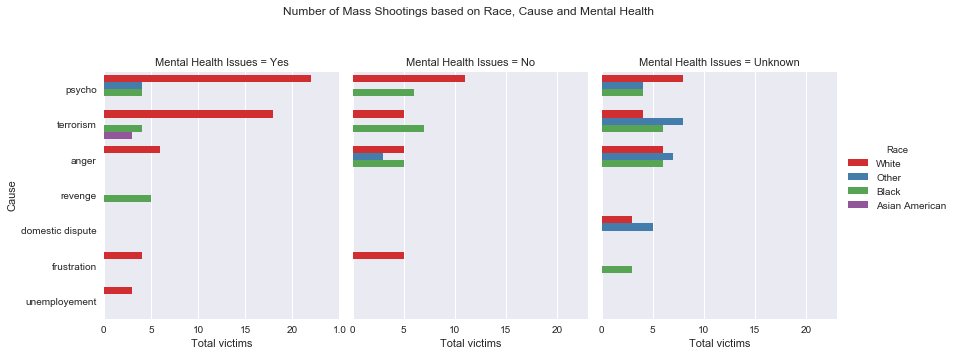

In [41]:
g = sns.factorplot(x='Total victims', y='Cause', col='Mental Health Issues', hue= 'Race', kind='bar', 
                   data=ms_health_cnt[ms_health_cnt['Total victims'] > 2], saturation=.8, size=5,
               ci=None, aspect=.8, col_wrap=3, palette='Set1')
g.set_xticklabels(step=1)
plt.subplots_adjust(top=0.8)
g.fig.suptitle('Number of Mass Shootings based on Race, Cause and Mental Health')

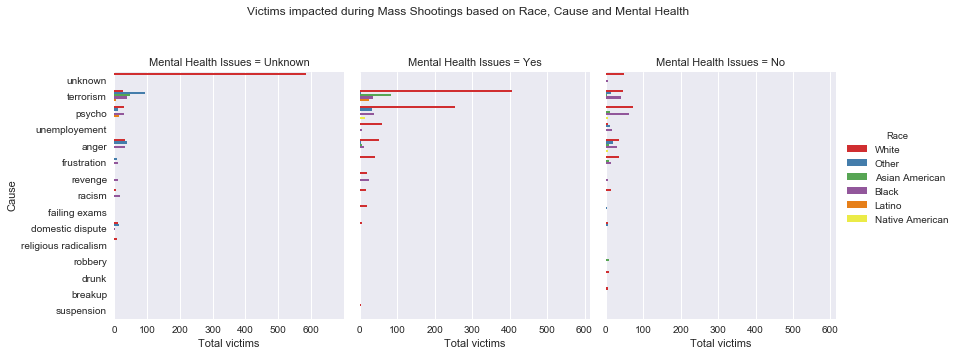

In [42]:
g = sns.factorplot(x='Total victims', y='Cause', col='Mental Health Issues', hue= 'Race', kind='bar', 
                   data=ms_health_sum[ms_health_sum['Total victims'] > 2], saturation=.8, size=5,
               ci=None, aspect=.8, col_wrap=3, palette='Set1')
g.set_xticklabels(step=1)
plt.subplots_adjust(top=0.8)
g.fig.suptitle('Victims impacted during Mass Shootings based on Race, Cause and Mental Health')

> Unknown mental health state is a scary issue. There are many people with mental health issues due to abusive childhood, bullies, poisonous environment, job opportunities etc. Apparently not much has been done to deal with mental health problems in North America. Medicine cannot solve this issue.  Main factor to solve this problem is to have great community of people around. Thats just too difficult to find. 

In [43]:
impute_grps = shootings.pivot_table(values=["Total victims"], index=["Shooting_Year","Race","Cause"], aggfunc=np.sum)
print(impute_grps)

                                               Total victims
Shooting_Year Race           Cause                          
1966          White          terrorism                    54
1971          White          terrorism                     5
1972          Black          psycho                       22
1974          Other          anger                         4
              White          terrorism                    10
1976          White          anger                         8
                             terrorism                     9
1979          White          terrorism                    11
1982          White          psycho                       11
1983          Asian American terrorism                    14
              White          anger                         4
1984          Black          terrorism                    14
              White          psycho                       40
                             revenge                       7
1985          Black     

### 3.5) Which state has more mass shootings?

In [44]:
ms_state = pd.DataFrame(ms[['State','Shooting_Year', 'Latitude', 'Longitude', 'Fatalities']][ms['Fatalities']>0].sort_values(by='Fatalities', ascending=False))
ms_state['Desc'] = ms_state['State'] + '<br>Year ' + (ms_state['Shooting_Year']).astype(str) + '<br>Fatalities ' + (ms_state['Fatalities']).astype(str)
ms_state.head()

,State,Shooting_Year,Latitude,Longitude,Fatalities,Desc
3,Nevada,2017,36.181271,-115.134132,59,Nevada<br>Year 2017<br>Fatalities 59
13,Florida,2016,NaN,NaN,49,Florida<br>Year 2016<br>Fatalities 49
220,Virginia,2007,37.229573,-80.413939,32,Virginia<br>Year 2007<br>Fatalities 32
176,Connecticut,2012,41.411908,-73.311963,28,Connecticut<br>Year 2012<br>Fatalities 28
0,Texas,2017,NaN,NaN,26,Texas<br>Year 2017<br>Fatalities 26


In [45]:
limits = [(0,1),(2,10),(11,50),(51,236),(237,350)]
colors = ["rgb(255,0,0)","rgb(128,0,128)","rgb(0,255,255)","rgb(173,255,47)", "rgb(0,0,255)"]
states = []

for i in range(len(limits)):
    lim = limits[i]
    ms_state_df = ms_state[lim[0]:lim[1]]
    state = dict(
        type = 'scattergeo',
        locationmode = 'USA-states',
        lon = ms_state_df[ms_state_df['Longitude'].notnull()]['Longitude'],
        lat = ms_state_df[ms_state_df['Longitude'].notnull()]['Latitude'],
        text = ms_state_df[ms_state_df['Longitude'].notnull()]['Desc'],
        marker = dict(
            size = ms_state_df[ms_state_df['Longitude'].notnull()]['Fatalities']**2 ,
            color = colors[i],
            line = dict(width=0.5, color='rgb(40,40,40)'),
            sizemode = 'area'
        ),
        name = 'Fatalities >='+(ms_state.loc[lim[0],'Fatalities']).astype(str)  )
    states.append(state)
        
layout = dict(
        title = 'Mass shootings in US 1966-2017',
        showlegend = True,
        geo = dict(
            scope='usa',
            projection=dict( type='albers usa' ),
            showland = True,
            landcolor = 'rgb(217, 217, 217)',
            subunitwidth=1,
            countrywidth=1,
            subunitcolor="rgb(255, 255, 255)",
            countrycolor="rgb(255, 255, 255)"
        ),
    )

fig = dict( data=states, layout=layout )
py.iplot( fig, validate=False, filename='US Mass Shootings' )

In [46]:
state = ms_state['State']
totvictims = ms_state['Fatalities']

layout = dict(
  title = 'US States that had most fatalities during Mass Shootings'
)    

data = [dict(
  type = 'bar',
  x = state,
  y = totvictims,
  mode = 'markers',
  transforms = [dict(
    type = 'aggregate',
    groups = state,
    aggregations = [dict(
        target = 'y', func = 'sum', ascending=False, enabled = True),
    ]
  )]
)]
py.iplot({'data': data, 'layout': layout}, validate=False)

### 3.6) School Shootings???

In [47]:
ms_school = ms[['Shooting_Year', 'Fatalities', 'Injured', 'Total victims','State','Race','Cause','Mental Health Issues',
                'FTarget', 'Area']][ms['Area'] == 'School']
ms_school.head()

,Shooting_Year,Fatalities,Injured,Total victims,State,Race,Cause,Mental Health Issues,FTarget,Area
91,2015,1,3,4,Arizona,White,anger,Unknown,School,School
92,2015,10,7,16,Oregon,Other,terrorism,Unknown,School,School
148,2014,1,3,3,Florida,Black,terrorism,Yes,Random,School
153,2014,1,2,3,Washington,Other,terrorism,Yes,School,School
187,2012,7,3,10,California,Asian American,terrorism,Yes,Random,School


In [48]:
ms_school0 = ms_school[['Shooting_Year', 'Total victims' ]].groupby(['Shooting_Year'], as_index=False).sum().sort_values(by='Shooting_Year', ascending=False)
ms_school1 = ms_school[['Shooting_Year', 'Fatalities' ]].groupby(['Shooting_Year'], as_index=False).sum().sort_values(by='Shooting_Year', ascending=False)
ms_school2 = ms_school[['Shooting_Year', 'Injured' ]].groupby(['Shooting_Year'], as_index=False).sum().sort_values(by='Shooting_Year', ascending=False)
ms_school3 = ms_school[['Shooting_Year', 'Total victims' ]].groupby(['Shooting_Year'], as_index=False).count().sort_values(by='Shooting_Year', ascending=False)

# Create traces
trace0 = go.Scatter(
    x = ms_school0['Shooting_Year'],
    y = ms_school0['Total victims'],
    mode = 'lines',
    name = 'Total Victims'
)
trace1 = go.Scatter(
    x = ms_school1['Shooting_Year'],
    y = ms_school1['Fatalities'],
    mode = 'lines+markers',
    name = 'Fatalities'
)
trace2 = go.Scatter(
    x = ms_school2['Shooting_Year'],
    y = ms_school2['Injured'],
    mode = 'lines+markers',
    name = 'Injured'
)

trace3 = go.Scatter(
    x = ms_school3['Shooting_Year'],
    y = ms_school3['Total victims'],
    mode = 'lines+markers',
    name = 'Count of Mass Shootings'
)

layout = dict(
  title = 'Mass Shootings Stats in Schools'
)    
data = [trace0, trace1, trace2, trace3]
py.iplot({'data': data, 'layout': layout}, filename='Mass shooting Fatalities in Schools')

In [49]:
ms_sch_target_cnt = ms_school[['FTarget', 'Total victims' ]].groupby(['FTarget'], as_index=False).count().sort_values(by='Total victims', ascending=False)
ms_sch_target_sum = ms_school[['FTarget', 'Total victims' ]].groupby(['FTarget'], as_index=False).sum().sort_values(by='Total victims', ascending=False)



values1 = ms_sch_target_cnt['Total victims']
labels1 = ms_sch_target_cnt['FTarget']
values2 = ms_sch_target_sum['Total victims']
labels2 = ms_sch_target_sum['FTarget']
fig = {
  "data": [
    {
      "values": values1,
      "labels": labels1,
      "domain": {"x": [0, .48]},
      "hoverinfo":"label+percent+name",
      "hole": .4,
      "type": "pie"
    },     
    {
      "values": values2,
      "labels": labels2,
      "domain": {"x": [.52, 1]},
      "hoverinfo":"label+percent+name",
      "hole": .4,
      "type": "pie"
    }],
  "layout": {
        "title":"School shooters and their Targets",
        "annotations": [
            {
                "font": {
                    "size": 12
                },
                "showarrow": False,
                "text": "More Shootings Target",
                "x": 0.20,
                "y": 0.5
            },
            {
                "font": {
                    "size": 12
                },
                "showarrow": False,
                "text": "More Victims Target",
                "x": 0.8,
                "y": 0.5
            }
        ]
    }
}
py.iplot(fig, filename='School Shootings')

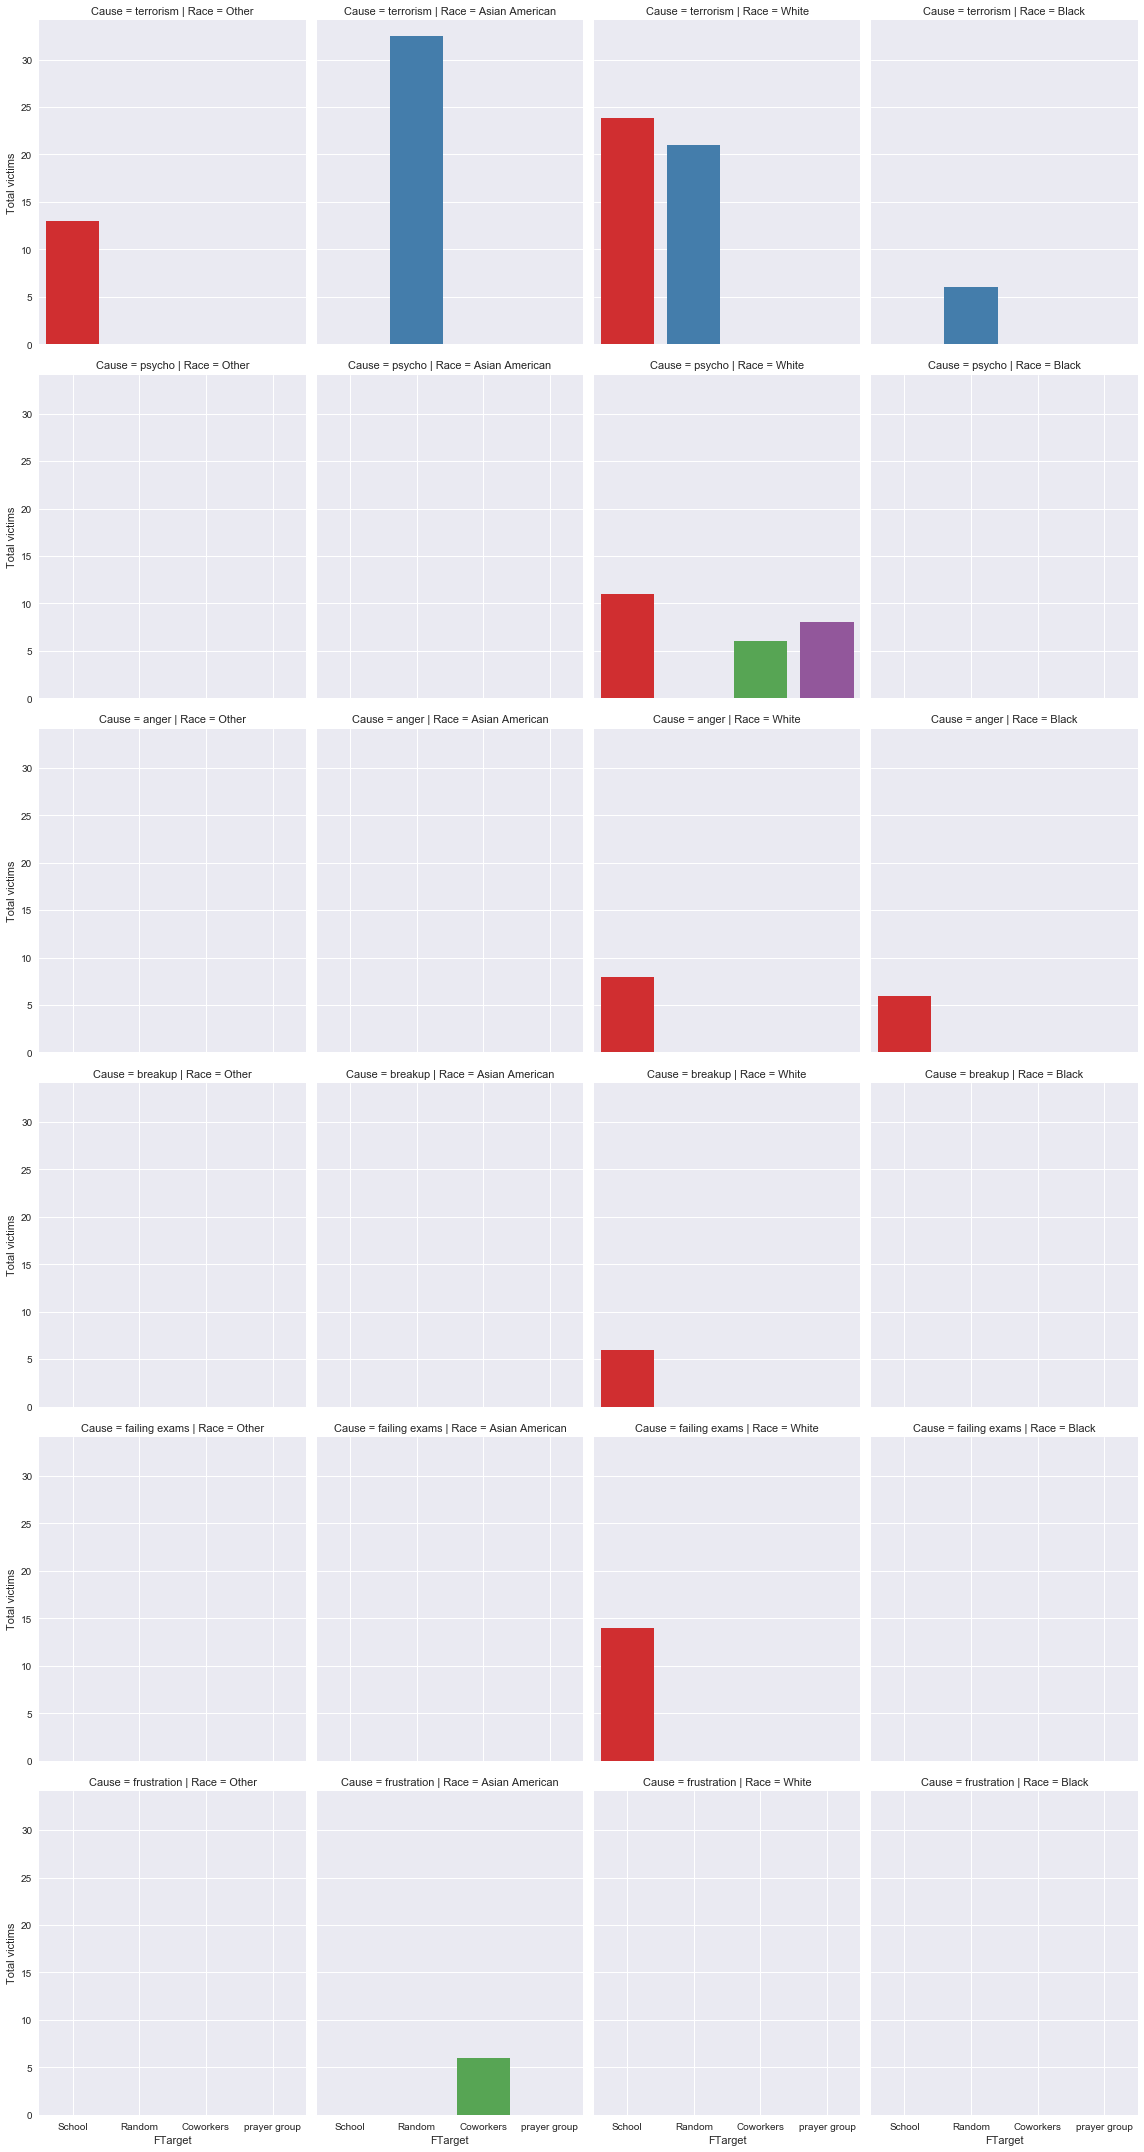

In [50]:
g = sns.factorplot(x='FTarget', y='Total victims', col='Race', row= 'Cause', kind='bar', 
                   data=ms_school[ms_school['Total victims']>5], saturation=.8, size=5,
               ci=None, aspect=.8,  palette='Set1')
g.set_xticklabels(step=1)

### 3.6) Any inference based on gender?

In [51]:
ms_gender = ms[['Shooting_Year','Gender','Fatalities','Injured', 'Total victims']].sort_values(ascending=False, by='Total victims')
ms_gender.head()

,Shooting_Year,Gender,Fatalities,Injured,Total victims
3,2017,Male,59,527,585
13,2016,Male,49,53,102
182,2012,Male,12,70,82
220,2007,Male,32,23,55
322,1966,Male,17,32,48


In [52]:
gender = ms_gender['Gender']
totvictims = ms_gender['Total victims']

layout = dict(
  title = 'Mass Shootings and Gender'
)    

data = [dict(
  type = 'scatter',
  x = gender,
  y = totvictims,
  mode = 'markers',
  transforms = [dict(
    type = 'aggregate',
    groups = gender,
    aggregations = [dict(
        target = 'y', func = 'sum', ascending=False, enabled = True),
    ]
  )]
)]
py.iplot({'data': data, 'layout': layout}, validate=False)